In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
import heapq
import time

# Load data

In [2]:
batch_num = 1
hidden_num = 45
step_num = 140
elem_num = 1
init_wins = 500
acc_size = 3*step_num #vn1 size, used for estimating mu and sigma during initialization
ecg = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/ecg.csv",names=["value","label"],skiprows=step_num*init_wins)
test_set = ecg.value
labels = ecg.label
wins =ecg.shape[0]//step_num
test_set_list = [test_set.as_matrix().reshape(wins,batch_num,step_num,elem_num)[a] for a in range(wins)]


In [3]:
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
normal_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        normal_index.append(count)
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[2731, 2804, 2813, 2815, 2890, 2926, 2929, 3049, 3250, 3324, 3325, 3351, 3352, 3360, 3412, 3413, 3474, 3507, 4334, 4337, 4339, 4383]


# Load Model

In [4]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/ecg/"
modelmeta_p = modelpath_root + "_1_45_140_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/ecg/_1_45_140_para.ckpt


In [5]:
print(mu,sigma,threshold)

0.0131334 0.000334831 0.000661553


# Online Phase (With expert)

In [6]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [7]:
acc_size = 3*step_num
def update(err_nbuf,acc_size,mu,sigma,retraining=False):       
        # acc_size is the amount of data that used until now for estimating mu and sigma

        current_size = len(err_nbuf)
        p = current_size/(current_size+acc_size) if retraining == False else 1

        tmp_errBuffer = err_nbuf[:current_size]
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu_new = p*__mu + (1-p)*mu

        __sigma =np.var(err_vec_array.ravel())
        sigma_new = p*__sigma + (1-p)*sigma + p*(1-p)*(mu-mu_new)*(mu-mu_new)
        print("new mu %.3f, new sigma %.3f, acc: %d"%(mu_new,sigma_new,current_size+acc_size))
        
        
        return mu_new, sigma_new

In [8]:
def get_threshold(normal_score, abnormal_score):
        upper = np.median(np.array(abnormal_score))
        lower = np.median(np.array(normal_score)) 
        scala = 20
        delta = (upper-lower) / scala
        candidate = lower
        threshold = 0
        result = 0

        def evaluate(threshold,normal_score,abnormal_score):

            beta = 0.5
            tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
            fp = len(abnormal_score)-tp
            fn = np.array(normal_score)[np.array(normal_score)>threshold].size
            tn = len(normal_score)- fn

            if tp == 0: return 0

            P = tp/(tp+fp)
            R = tp/(tp+fn)
            fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
            return fbeta 

        for _ in range(scala):
            r = evaluate(candidate,normal_score,abnormal_score)
            if r > result:
                result = r 
                threshold = candidate
            candidate += delta 
        return threshold

In [9]:
def update_parameter(err_nbuf,err_abuf,acc_size,mu,sigma,threshold):       
        # acc_size is the amount of data that used until now for estimating mu and sigma
        print("Estimating new parameters...")
        
        current_size = len(err_nbuf)*2//3
        p = current_size/(current_size+acc_size)
        
        tmp_errBuffer = err_nbuf[:current_size]
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu_new = p*__mu + (1-p)*mu

        __sigma =np.var(err_vec_array.ravel())
        sigma_new = p*__sigma + (1-p)*sigma + p*(1-p)*(mu-mu_new)*(mu-mu_new)
        
        _score_n = scoring(np.array(err_nbuf[current_size:]).reshape(-1,elem_num),mu_new,sigma_new) 
        _score_a = scoring(np.array(err_abuf).reshape(-1,elem_num),mu_new,sigma_new) 
        
        scores = pd.Series(_score_n + _score_a)
        label = pd.Series( ["normal"]*len(_score_n) + ["anomaly"]*len(_score_a))
        
        upper = max(np.array(_score_a).max(),np.array(_score_n).max())
        lower = min(np.array(_score_a).max(),np.array(_score_n).max())
        scala = 20
        delta = (upper-lower) / scala
        cand = (upper+lower)/2
        __threshold = 0
        result = 0
        print(np.array(_score_a).max(),np.array(_score_n).max())
        candidates = []
        for s in range(scala):
            candidates.append( cand + (s+1)*delta)
            candidates.append( cand - (s+1)*delta)
            
        for candidate in candidates:
            r = evaluate(candidate,scores,label)
            if r > result:
                result = r 
                __threshold = candidate
           

            
        threshold_new = __threshold
        print("New parameters learned!")
        
        return mu_new,sigma_new,threshold_new

In [10]:
def evaluate(threoshld,scores,label):

    beta = 1
    tp = len(set(scores[ scores > threshold].index) & set( label[label=='anomaly'].index))
    fn = len(set(scores[ scores > threshold].index) & set(label[label=='normal'].index))
    fp = len(set(scores[ scores <= threshold].index) & set( label[label=='anomaly'].index))
    tn = len(set(scores[ scores <= threshold].index) & set(label[label=='normal'].index))

    

    if tp == 0: 
        print("TP is 0.")
        return 0
    

    P = tp/(tp+fp) # reduce the number of didn't detected anomaly
    R = tp/(tp+fn) # recuce the number of normal points that predicted as abnormal
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    return fbeta

In [11]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def local_preprocessing(batchdata):
    # input batchdata with shape : [batch_num, step_num, elem_num]
    # minmax scaler on window level
    df = pd.DataFrame()
    
    for window in batchdata:
        
        scaler = MinMaxScaler()
        scaler.fit(window)
        new_win = scaler.transform(window)
        df = pd.concat((df, pd.DataFrame(new_win)),axis=0) if df.size!=0 else pd.DataFrame(new_win)
    return df.as_matrix().reshape(batchdata.shape)

    

In [13]:
mus = [mu]
sigmas = [sigma]

new mu 0.013, new sigma 0.000, acc: 421
new mu 0.013, new sigma 0.000, acc: 562
new mu 0.013, new sigma 0.000, acc: 703
new mu 0.013, new sigma 0.000, acc: 844
new mu 0.013, new sigma 0.000, acc: 985
new mu 0.013, new sigma 0.000, acc: 1126
new mu 0.013, new sigma 0.000, acc: 1267
new mu 0.013, new sigma 0.000, acc: 1408
new mu 0.013, new sigma 0.000, acc: 1549
new mu 0.014, new sigma 0.000, acc: 1690
new mu 0.014, new sigma 0.000, acc: 1831
new mu 0.014, new sigma 0.000, acc: 1972
new mu 0.014, new sigma 0.000, acc: 2113
new mu 0.014, new sigma 0.000, acc: 2254
new mu 0.014, new sigma 0.000, acc: 2395
new mu 0.014, new sigma 0.000, acc: 2536
new mu 0.014, new sigma 0.000, acc: 2677
new mu 0.014, new sigma 0.000, acc: 2818
new mu 0.014, new sigma 0.000, acc: 2959
new mu 0.014, new sigma 0.000, acc: 3100
new mu 0.014, new sigma 0.000, acc: 3241
new mu 0.014, new sigma 0.000, acc: 3382
new mu 0.014, new sigma 0.000, acc: 3523
new mu 0.014, new sigma 0.000, acc: 3664
new mu 0.014, new sig

new mu 0.019, new sigma 0.001, acc: 28339
new mu 0.019, new sigma 0.001, acc: 28480
new mu 0.019, new sigma 0.001, acc: 28621
new mu 0.019, new sigma 0.001, acc: 28762
new mu 0.019, new sigma 0.001, acc: 28903
new mu 0.019, new sigma 0.001, acc: 29044
new mu 0.019, new sigma 0.001, acc: 29185
new mu 0.019, new sigma 0.001, acc: 29326
new mu 0.019, new sigma 0.001, acc: 29467
new mu 0.019, new sigma 0.001, acc: 29608
new mu 0.020, new sigma 0.001, acc: 29749
new mu 0.020, new sigma 0.001, acc: 29890
new mu 0.020, new sigma 0.001, acc: 30031
new mu 0.020, new sigma 0.001, acc: 30172
new mu 0.020, new sigma 0.001, acc: 30313
new mu 0.020, new sigma 0.001, acc: 30454
new mu 0.020, new sigma 0.001, acc: 30595
new mu 0.020, new sigma 0.001, acc: 30736
new mu 0.020, new sigma 0.001, acc: 30877
new mu 0.020, new sigma 0.001, acc: 31018
new mu 0.020, new sigma 0.001, acc: 31159
new mu 0.020, new sigma 0.001, acc: 31300
new mu 0.020, new sigma 0.001, acc: 31441
new mu 0.020, new sigma 0.001, acc

new mu 0.021, new sigma 0.001, acc: 56116
new mu 0.021, new sigma 0.001, acc: 56257
new mu 0.021, new sigma 0.001, acc: 56398
new mu 0.021, new sigma 0.001, acc: 56539
new mu 0.021, new sigma 0.001, acc: 56680
new mu 0.021, new sigma 0.001, acc: 56821
new mu 0.021, new sigma 0.001, acc: 56962
new mu 0.021, new sigma 0.001, acc: 57103
new mu 0.021, new sigma 0.001, acc: 57244
new mu 0.021, new sigma 0.001, acc: 57385
new mu 0.021, new sigma 0.001, acc: 57526
new mu 0.021, new sigma 0.001, acc: 57667
new mu 0.021, new sigma 0.001, acc: 57808
new mu 0.021, new sigma 0.001, acc: 57949
new mu 0.021, new sigma 0.001, acc: 58090
new mu 0.021, new sigma 0.001, acc: 58231
new mu 0.021, new sigma 0.001, acc: 58372
new mu 0.021, new sigma 0.001, acc: 58513
new mu 0.021, new sigma 0.001, acc: 58654
new mu 0.021, new sigma 0.001, acc: 58795
new mu 0.021, new sigma 0.001, acc: 58936
new mu 0.021, new sigma 0.001, acc: 59077
new mu 0.021, new sigma 0.001, acc: 59218
new mu 0.021, new sigma 0.001, acc

new mu 0.021, new sigma 0.001, acc: 84034
new mu 0.021, new sigma 0.001, acc: 84175
new mu 0.021, new sigma 0.001, acc: 84316
new mu 0.021, new sigma 0.001, acc: 84457
new mu 0.021, new sigma 0.001, acc: 84598
new mu 0.021, new sigma 0.001, acc: 84739
new mu 0.021, new sigma 0.001, acc: 84880
new mu 0.021, new sigma 0.001, acc: 85021
new mu 0.021, new sigma 0.001, acc: 85162
new mu 0.021, new sigma 0.001, acc: 85303
new mu 0.021, new sigma 0.001, acc: 85444
new mu 0.021, new sigma 0.001, acc: 85585
new mu 0.021, new sigma 0.001, acc: 85726
new mu 0.021, new sigma 0.001, acc: 85867
new mu 0.021, new sigma 0.001, acc: 86008
new mu 0.021, new sigma 0.001, acc: 86149
new mu 0.021, new sigma 0.001, acc: 86290
new mu 0.021, new sigma 0.001, acc: 86431
new mu 0.021, new sigma 0.001, acc: 86572
new mu 0.021, new sigma 0.001, acc: 86713
new mu 0.021, new sigma 0.001, acc: 86854
new mu 0.021, new sigma 0.001, acc: 86995
new mu 0.021, new sigma 0.001, acc: 87136
new mu 0.021, new sigma 0.001, acc

new mu 0.021, new sigma 0.001, acc: 112234
new mu 0.021, new sigma 0.001, acc: 112375
new mu 0.021, new sigma 0.001, acc: 112516
new mu 0.021, new sigma 0.001, acc: 112657
new mu 0.021, new sigma 0.001, acc: 112798
new mu 0.021, new sigma 0.001, acc: 112939
new mu 0.021, new sigma 0.001, acc: 113080
new mu 0.021, new sigma 0.001, acc: 113221
new mu 0.021, new sigma 0.001, acc: 113362
new mu 0.021, new sigma 0.001, acc: 113503
new mu 0.021, new sigma 0.001, acc: 113644
new mu 0.021, new sigma 0.001, acc: 113785
new mu 0.021, new sigma 0.001, acc: 113926
new mu 0.021, new sigma 0.001, acc: 114067
new mu 0.021, new sigma 0.001, acc: 114208
new mu 0.021, new sigma 0.001, acc: 114349
new mu 0.021, new sigma 0.001, acc: 114490
new mu 0.021, new sigma 0.001, acc: 114631
new mu 0.021, new sigma 0.001, acc: 114772
new mu 0.021, new sigma 0.001, acc: 114913
new mu 0.021, new sigma 0.001, acc: 115054
new mu 0.021, new sigma 0.001, acc: 115195
new mu 0.021, new sigma 0.001, acc: 115336
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 139588
new mu 0.021, new sigma 0.001, acc: 139729
new mu 0.021, new sigma 0.001, acc: 139870
new mu 0.021, new sigma 0.001, acc: 140011
new mu 0.021, new sigma 0.001, acc: 140152
new mu 0.021, new sigma 0.001, acc: 140293
new mu 0.021, new sigma 0.001, acc: 140434
new mu 0.021, new sigma 0.001, acc: 140575
new mu 0.021, new sigma 0.001, acc: 140716
new mu 0.021, new sigma 0.001, acc: 140857
new mu 0.021, new sigma 0.001, acc: 140998
new mu 0.021, new sigma 0.001, acc: 141139
new mu 0.021, new sigma 0.001, acc: 141280
new mu 0.021, new sigma 0.001, acc: 141421
new mu 0.021, new sigma 0.001, acc: 141562
new mu 0.021, new sigma 0.001, acc: 141703
new mu 0.021, new sigma 0.001, acc: 141844
new mu 0.021, new sigma 0.001, acc: 141985
new mu 0.021, new sigma 0.001, acc: 142126
new mu 0.021, new sigma 0.001, acc: 142267
new mu 0.021, new sigma 0.001, acc: 142408
new mu 0.021, new sigma 0.001, acc: 142549
new mu 0.021, new sigma 0.001, acc: 142690
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 167224
new mu 0.021, new sigma 0.001, acc: 167365
new mu 0.021, new sigma 0.001, acc: 167506
new mu 0.021, new sigma 0.001, acc: 167647
new mu 0.021, new sigma 0.001, acc: 167788
new mu 0.021, new sigma 0.001, acc: 167929
new mu 0.021, new sigma 0.001, acc: 168070
new mu 0.021, new sigma 0.001, acc: 168211
new mu 0.021, new sigma 0.001, acc: 168352
new mu 0.021, new sigma 0.001, acc: 168493
new mu 0.021, new sigma 0.001, acc: 168634
new mu 0.021, new sigma 0.001, acc: 168775
new mu 0.021, new sigma 0.001, acc: 168916
new mu 0.021, new sigma 0.001, acc: 169057
new mu 0.021, new sigma 0.001, acc: 169198
new mu 0.021, new sigma 0.001, acc: 169339
new mu 0.021, new sigma 0.001, acc: 169480
new mu 0.021, new sigma 0.001, acc: 169621
new mu 0.021, new sigma 0.001, acc: 169762
new mu 0.021, new sigma 0.001, acc: 169903
new mu 0.021, new sigma 0.001, acc: 170044
new mu 0.021, new sigma 0.001, acc: 170185
new mu 0.021, new sigma 0.001, acc: 170326
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 194155
new mu 0.021, new sigma 0.001, acc: 194296
new mu 0.021, new sigma 0.001, acc: 194437
new mu 0.021, new sigma 0.001, acc: 194578
new mu 0.021, new sigma 0.001, acc: 194719
new mu 0.021, new sigma 0.001, acc: 194860
new mu 0.021, new sigma 0.001, acc: 195001
new mu 0.021, new sigma 0.001, acc: 195142
new mu 0.021, new sigma 0.001, acc: 195283
new mu 0.021, new sigma 0.001, acc: 195424
new mu 0.021, new sigma 0.001, acc: 195565
new mu 0.021, new sigma 0.001, acc: 195706
new mu 0.021, new sigma 0.001, acc: 195847
new mu 0.021, new sigma 0.001, acc: 195988
new mu 0.021, new sigma 0.001, acc: 196129
new mu 0.021, new sigma 0.001, acc: 196270
new mu 0.021, new sigma 0.001, acc: 196411
new mu 0.021, new sigma 0.001, acc: 196552
new mu 0.021, new sigma 0.001, acc: 196693
new mu 0.021, new sigma 0.001, acc: 196834
new mu 0.021, new sigma 0.001, acc: 196975
new mu 0.021, new sigma 0.001, acc: 197116
new mu 0.021, new sigma 0.001, acc: 197257
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 221086
new mu 0.021, new sigma 0.001, acc: 221227
new mu 0.021, new sigma 0.001, acc: 221368
new mu 0.021, new sigma 0.001, acc: 221509
new mu 0.021, new sigma 0.001, acc: 221650
new mu 0.021, new sigma 0.001, acc: 221791
new mu 0.021, new sigma 0.001, acc: 221932
new mu 0.021, new sigma 0.001, acc: 222073
new mu 0.021, new sigma 0.001, acc: 222214
new mu 0.021, new sigma 0.001, acc: 222355
new mu 0.021, new sigma 0.001, acc: 222496
new mu 0.021, new sigma 0.001, acc: 222637
new mu 0.021, new sigma 0.001, acc: 222778
new mu 0.021, new sigma 0.001, acc: 222919
new mu 0.021, new sigma 0.001, acc: 223060
new mu 0.021, new sigma 0.001, acc: 223201
new mu 0.021, new sigma 0.001, acc: 223342
new mu 0.021, new sigma 0.001, acc: 223483
new mu 0.021, new sigma 0.001, acc: 223624
new mu 0.021, new sigma 0.001, acc: 223765
new mu 0.021, new sigma 0.001, acc: 223906
new mu 0.021, new sigma 0.001, acc: 224047
new mu 0.021, new sigma 0.001, acc: 224188
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 248863
new mu 0.021, new sigma 0.001, acc: 249004
new mu 0.021, new sigma 0.001, acc: 249145
new mu 0.021, new sigma 0.001, acc: 249286
new mu 0.021, new sigma 0.001, acc: 249427
new mu 0.021, new sigma 0.001, acc: 249568
new mu 0.021, new sigma 0.001, acc: 249709
new mu 0.021, new sigma 0.001, acc: 249850
new mu 0.021, new sigma 0.001, acc: 249991
new mu 0.021, new sigma 0.001, acc: 250132
new mu 0.021, new sigma 0.001, acc: 250273
new mu 0.021, new sigma 0.001, acc: 250414
new mu 0.021, new sigma 0.001, acc: 250555
new mu 0.021, new sigma 0.001, acc: 250696
new mu 0.021, new sigma 0.001, acc: 250837
new mu 0.021, new sigma 0.001, acc: 250978
new mu 0.021, new sigma 0.001, acc: 251119
new mu 0.021, new sigma 0.001, acc: 251260
new mu 0.021, new sigma 0.001, acc: 251401
new mu 0.021, new sigma 0.001, acc: 251542
new mu 0.021, new sigma 0.001, acc: 251683
new mu 0.021, new sigma 0.001, acc: 251824
new mu 0.021, new sigma 0.001, acc: 251965
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 276499
new mu 0.021, new sigma 0.001, acc: 276640
new mu 0.021, new sigma 0.001, acc: 276781
new mu 0.021, new sigma 0.001, acc: 276922
new mu 0.021, new sigma 0.001, acc: 277063
new mu 0.021, new sigma 0.001, acc: 277204
new mu 0.021, new sigma 0.001, acc: 277345
new mu 0.021, new sigma 0.001, acc: 277486
new mu 0.021, new sigma 0.001, acc: 277627
new mu 0.021, new sigma 0.001, acc: 277768
new mu 0.021, new sigma 0.001, acc: 277909
new mu 0.021, new sigma 0.001, acc: 278050
new mu 0.021, new sigma 0.001, acc: 278191
new mu 0.021, new sigma 0.001, acc: 278332
new mu 0.021, new sigma 0.001, acc: 278473
new mu 0.021, new sigma 0.001, acc: 278614
new mu 0.021, new sigma 0.001, acc: 278755
new mu 0.021, new sigma 0.001, acc: 278896
new mu 0.021, new sigma 0.001, acc: 279037
new mu 0.021, new sigma 0.001, acc: 279178
new mu 0.021, new sigma 0.001, acc: 279319
new mu 0.021, new sigma 0.001, acc: 279460
new mu 0.021, new sigma 0.001, acc: 279601
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 303430
new mu 0.021, new sigma 0.001, acc: 303571
new mu 0.021, new sigma 0.001, acc: 303712
new mu 0.021, new sigma 0.001, acc: 303853
new mu 0.021, new sigma 0.001, acc: 303994
new mu 0.021, new sigma 0.001, acc: 304135
new mu 0.021, new sigma 0.001, acc: 304276
new mu 0.021, new sigma 0.001, acc: 304417
new mu 0.021, new sigma 0.001, acc: 304558
new mu 0.021, new sigma 0.001, acc: 304699
new mu 0.021, new sigma 0.001, acc: 304840
new mu 0.021, new sigma 0.001, acc: 304981
new mu 0.021, new sigma 0.001, acc: 305122
new mu 0.021, new sigma 0.001, acc: 305263
new mu 0.021, new sigma 0.001, acc: 305404
new mu 0.021, new sigma 0.001, acc: 305545
new mu 0.021, new sigma 0.001, acc: 305686
new mu 0.021, new sigma 0.001, acc: 305827
new mu 0.021, new sigma 0.001, acc: 305968
new mu 0.021, new sigma 0.001, acc: 306109
new mu 0.021, new sigma 0.001, acc: 306250
new mu 0.021, new sigma 0.001, acc: 306391
new mu 0.021, new sigma 0.001, acc: 306532
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 331207
new mu 0.021, new sigma 0.001, acc: 331348
new mu 0.021, new sigma 0.001, acc: 331489
new mu 0.021, new sigma 0.001, acc: 331630
new mu 0.021, new sigma 0.001, acc: 331771
new mu 0.021, new sigma 0.001, acc: 331912
new mu 0.021, new sigma 0.001, acc: 332053
new mu 0.021, new sigma 0.001, acc: 332194
new mu 0.021, new sigma 0.001, acc: 332335
new mu 0.021, new sigma 0.001, acc: 332476
new mu 0.021, new sigma 0.001, acc: 332617
new mu 0.021, new sigma 0.001, acc: 332758
new mu 0.021, new sigma 0.001, acc: 332899
new mu 0.021, new sigma 0.001, acc: 333040
new mu 0.021, new sigma 0.001, acc: 333181
new mu 0.021, new sigma 0.001, acc: 333322
new mu 0.021, new sigma 0.001, acc: 333463
new mu 0.021, new sigma 0.001, acc: 333604
new mu 0.021, new sigma 0.001, acc: 333745
new mu 0.021, new sigma 0.001, acc: 333886
new mu 0.021, new sigma 0.001, acc: 334027
new mu 0.021, new sigma 0.001, acc: 334168
new mu 0.021, new sigma 0.001, acc: 334309
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 358420
new mu 0.021, new sigma 0.001, acc: 358561
new mu 0.021, new sigma 0.001, acc: 358702
new mu 0.021, new sigma 0.001, acc: 358843
new mu 0.021, new sigma 0.001, acc: 358984
new mu 0.021, new sigma 0.001, acc: 359125
new mu 0.021, new sigma 0.001, acc: 359266
new mu 0.021, new sigma 0.001, acc: 359407
new mu 0.021, new sigma 0.001, acc: 359548
new mu 0.021, new sigma 0.001, acc: 359689
new mu 0.021, new sigma 0.001, acc: 359830
new mu 0.021, new sigma 0.001, acc: 359971
new mu 0.021, new sigma 0.001, acc: 360112
new mu 0.021, new sigma 0.001, acc: 360253
new mu 0.021, new sigma 0.001, acc: 360394
new mu 0.021, new sigma 0.001, acc: 360535
new mu 0.021, new sigma 0.001, acc: 360676
new mu 0.021, new sigma 0.001, acc: 360817
new mu 0.021, new sigma 0.001, acc: 360958
new mu 0.021, new sigma 0.001, acc: 361099
new mu 0.021, new sigma 0.001, acc: 361240
new mu 0.021, new sigma 0.001, acc: 361381
new mu 0.021, new sigma 0.001, acc: 361522
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 385492
new mu 0.021, new sigma 0.001, acc: 385633
new mu 0.021, new sigma 0.001, acc: 385774
new mu 0.021, new sigma 0.001, acc: 385915
new mu 0.021, new sigma 0.001, acc: 386056
new mu 0.021, new sigma 0.001, acc: 386197
new mu 0.021, new sigma 0.001, acc: 386338
new mu 0.021, new sigma 0.001, acc: 386479
new mu 0.021, new sigma 0.001, acc: 386620
new mu 0.021, new sigma 0.001, acc: 386761
new mu 0.021, new sigma 0.001, acc: 386902
new mu 0.021, new sigma 0.001, acc: 387043
new mu 0.021, new sigma 0.001, acc: 387184
new mu 0.021, new sigma 0.001, acc: 387325
new mu 0.021, new sigma 0.001, acc: 387466
new mu 0.021, new sigma 0.001, acc: 387607
new mu 0.021, new sigma 0.001, acc: 387748
new mu 0.021, new sigma 0.001, acc: 387889
new mu 0.021, new sigma 0.001, acc: 388030
new mu 0.021, new sigma 0.001, acc: 388171
new mu 0.021, new sigma 0.001, acc: 388312
new mu 0.021, new sigma 0.001, acc: 388453
new mu 0.021, new sigma 0.001, acc: 388594
new mu 0.02

new mu 0.022, new sigma 0.001, acc: 412987
new mu 0.022, new sigma 0.001, acc: 413128
new mu 0.022, new sigma 0.001, acc: 413269
new mu 0.022, new sigma 0.001, acc: 413410
new mu 0.022, new sigma 0.001, acc: 413551
new mu 0.022, new sigma 0.001, acc: 413692
new mu 0.022, new sigma 0.001, acc: 413833
new mu 0.022, new sigma 0.001, acc: 413974
new mu 0.022, new sigma 0.001, acc: 414115
new mu 0.022, new sigma 0.001, acc: 414256
new mu 0.022, new sigma 0.001, acc: 414397
new mu 0.022, new sigma 0.001, acc: 414538
new mu 0.022, new sigma 0.001, acc: 414679
new mu 0.022, new sigma 0.001, acc: 414820
new mu 0.022, new sigma 0.001, acc: 414961
new mu 0.022, new sigma 0.001, acc: 415102
new mu 0.022, new sigma 0.001, acc: 415243
new mu 0.022, new sigma 0.001, acc: 415384
new mu 0.022, new sigma 0.001, acc: 415525
new mu 0.022, new sigma 0.001, acc: 415666
new mu 0.022, new sigma 0.001, acc: 415807
new mu 0.022, new sigma 0.001, acc: 415948
new mu 0.022, new sigma 0.001, acc: 416089
new mu 0.02

new mu 0.022, new sigma 0.001, acc: 440341
new mu 0.022, new sigma 0.001, acc: 440482
new mu 0.022, new sigma 0.001, acc: 440623
new mu 0.022, new sigma 0.001, acc: 440764
new mu 0.022, new sigma 0.001, acc: 440905
new mu 0.022, new sigma 0.001, acc: 441046
new mu 0.022, new sigma 0.001, acc: 441187
new mu 0.022, new sigma 0.001, acc: 441328
new mu 0.022, new sigma 0.001, acc: 441469
new mu 0.022, new sigma 0.001, acc: 441610
new mu 0.022, new sigma 0.001, acc: 441751
new mu 0.022, new sigma 0.001, acc: 441892
new mu 0.022, new sigma 0.001, acc: 442033
new mu 0.022, new sigma 0.001, acc: 442174
new mu 0.022, new sigma 0.001, acc: 442315
new mu 0.022, new sigma 0.001, acc: 442456
new mu 0.022, new sigma 0.001, acc: 442597
new mu 0.022, new sigma 0.001, acc: 442738
new mu 0.022, new sigma 0.001, acc: 442879
new mu 0.022, new sigma 0.001, acc: 443020
new mu 0.022, new sigma 0.001, acc: 443161
new mu 0.022, new sigma 0.001, acc: 443302
new mu 0.022, new sigma 0.001, acc: 443443
new mu 0.02

new mu 0.023, new sigma 0.001, acc: 467695
retrain before 3325 batch
new mu 0.023, new sigma 0.001, acc: 467835
new mu 0.023, new sigma 0.001, acc: 467836
new mu 0.023, new sigma 0.001, acc: 467977
new mu 0.023, new sigma 0.001, acc: 468118
new mu 0.023, new sigma 0.001, acc: 468259
new mu 0.023, new sigma 0.001, acc: 468400
new mu 0.023, new sigma 0.001, acc: 468541
new mu 0.023, new sigma 0.001, acc: 468682
new mu 0.023, new sigma 0.001, acc: 468823
new mu 0.023, new sigma 0.001, acc: 468964
new mu 0.023, new sigma 0.001, acc: 469105
new mu 0.023, new sigma 0.001, acc: 469246
new mu 0.023, new sigma 0.001, acc: 469387
new mu 0.023, new sigma 0.001, acc: 469528
new mu 0.023, new sigma 0.001, acc: 469669
new mu 0.023, new sigma 0.001, acc: 469810
new mu 0.023, new sigma 0.001, acc: 469951
new mu 0.023, new sigma 0.001, acc: 470092
new mu 0.023, new sigma 0.001, acc: 470233
new mu 0.023, new sigma 0.001, acc: 470374
new mu 0.023, new sigma 0.001, acc: 470515
new mu 0.023, new sigma 0.00

new mu 0.023, new sigma 0.001, acc: 494767
new mu 0.023, new sigma 0.001, acc: 494908
new mu 0.023, new sigma 0.001, acc: 495049
new mu 0.023, new sigma 0.001, acc: 495190
new mu 0.023, new sigma 0.001, acc: 495331
new mu 0.023, new sigma 0.001, acc: 495472
new mu 0.023, new sigma 0.001, acc: 495613
new mu 0.023, new sigma 0.001, acc: 495754
new mu 0.023, new sigma 0.001, acc: 495895
new mu 0.023, new sigma 0.001, acc: 496036
new mu 0.023, new sigma 0.001, acc: 496177
new mu 0.023, new sigma 0.001, acc: 496318
new mu 0.023, new sigma 0.001, acc: 496459
new mu 0.023, new sigma 0.001, acc: 496600
new mu 0.023, new sigma 0.001, acc: 496741
new mu 0.023, new sigma 0.001, acc: 496882
new mu 0.023, new sigma 0.001, acc: 497023
new mu 0.023, new sigma 0.001, acc: 497164
new mu 0.023, new sigma 0.001, acc: 497305
new mu 0.023, new sigma 0.001, acc: 497446
new mu 0.023, new sigma 0.001, acc: 497587
new mu 0.023, new sigma 0.001, acc: 497728
new mu 0.023, new sigma 0.001, acc: 497869
new mu 0.02

new mu 0.022, new sigma 0.001, acc: 522403
new mu 0.022, new sigma 0.001, acc: 522544
new mu 0.022, new sigma 0.001, acc: 522685
new mu 0.022, new sigma 0.001, acc: 522826
new mu 0.022, new sigma 0.001, acc: 522967
new mu 0.022, new sigma 0.001, acc: 523108
new mu 0.022, new sigma 0.001, acc: 523249
new mu 0.022, new sigma 0.001, acc: 523390
new mu 0.022, new sigma 0.001, acc: 523531
new mu 0.022, new sigma 0.001, acc: 523672
new mu 0.022, new sigma 0.001, acc: 523813
new mu 0.022, new sigma 0.001, acc: 523954
new mu 0.022, new sigma 0.001, acc: 524095
new mu 0.022, new sigma 0.001, acc: 524236
new mu 0.022, new sigma 0.001, acc: 524377
new mu 0.022, new sigma 0.001, acc: 524518
new mu 0.022, new sigma 0.001, acc: 524659
new mu 0.022, new sigma 0.001, acc: 524800
new mu 0.022, new sigma 0.001, acc: 524941
new mu 0.022, new sigma 0.001, acc: 525082
new mu 0.022, new sigma 0.001, acc: 525223
new mu 0.022, new sigma 0.001, acc: 525364
new mu 0.022, new sigma 0.001, acc: 525505
new mu 0.02

new mu 0.022, new sigma 0.001, acc: 549334
new mu 0.022, new sigma 0.001, acc: 549475
new mu 0.022, new sigma 0.001, acc: 549616
new mu 0.022, new sigma 0.001, acc: 549757
new mu 0.022, new sigma 0.001, acc: 549898
new mu 0.022, new sigma 0.001, acc: 550039
new mu 0.022, new sigma 0.001, acc: 550180
new mu 0.022, new sigma 0.001, acc: 550321
new mu 0.022, new sigma 0.001, acc: 550462
new mu 0.022, new sigma 0.001, acc: 550603
new mu 0.022, new sigma 0.001, acc: 550744
new mu 0.022, new sigma 0.001, acc: 550885
new mu 0.022, new sigma 0.001, acc: 551026
new mu 0.022, new sigma 0.001, acc: 551167
new mu 0.022, new sigma 0.001, acc: 551308
new mu 0.022, new sigma 0.001, acc: 551449
new mu 0.022, new sigma 0.001, acc: 551590
new mu 0.022, new sigma 0.001, acc: 551731
new mu 0.022, new sigma 0.001, acc: 551872
new mu 0.022, new sigma 0.001, acc: 552013
new mu 0.022, new sigma 0.001, acc: 552154
new mu 0.022, new sigma 0.001, acc: 552295
new mu 0.022, new sigma 0.001, acc: 552436
new mu 0.02

new mu 0.022, new sigma 0.001, acc: 576265
new mu 0.022, new sigma 0.001, acc: 576406
new mu 0.022, new sigma 0.001, acc: 576547
new mu 0.022, new sigma 0.001, acc: 576688
new mu 0.021, new sigma 0.001, acc: 576829
new mu 0.021, new sigma 0.001, acc: 576970
new mu 0.021, new sigma 0.001, acc: 577111
new mu 0.021, new sigma 0.001, acc: 577252
new mu 0.021, new sigma 0.001, acc: 577393
new mu 0.021, new sigma 0.001, acc: 577534
new mu 0.021, new sigma 0.001, acc: 577675
new mu 0.021, new sigma 0.001, acc: 577816
new mu 0.021, new sigma 0.001, acc: 577957
new mu 0.021, new sigma 0.001, acc: 578098
new mu 0.021, new sigma 0.001, acc: 578239
new mu 0.021, new sigma 0.001, acc: 578380
new mu 0.021, new sigma 0.001, acc: 578521
new mu 0.021, new sigma 0.001, acc: 578662
new mu 0.021, new sigma 0.001, acc: 578803
new mu 0.021, new sigma 0.001, acc: 578944
new mu 0.021, new sigma 0.001, acc: 579085
new mu 0.021, new sigma 0.001, acc: 579226
new mu 0.021, new sigma 0.001, acc: 579367
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 603478
new mu 0.021, new sigma 0.001, acc: 603619
new mu 0.021, new sigma 0.001, acc: 603760
new mu 0.021, new sigma 0.001, acc: 603901
new mu 0.021, new sigma 0.001, acc: 604042
new mu 0.021, new sigma 0.001, acc: 604183
new mu 0.021, new sigma 0.001, acc: 604324
new mu 0.021, new sigma 0.001, acc: 604465
new mu 0.021, new sigma 0.001, acc: 604606
new mu 0.021, new sigma 0.001, acc: 604747
new mu 0.021, new sigma 0.001, acc: 604888
new mu 0.021, new sigma 0.001, acc: 605029
new mu 0.021, new sigma 0.001, acc: 605170
new mu 0.021, new sigma 0.001, acc: 605311
new mu 0.021, new sigma 0.001, acc: 605452
new mu 0.021, new sigma 0.001, acc: 605593
new mu 0.021, new sigma 0.001, acc: 605734
new mu 0.021, new sigma 0.001, acc: 605875
new mu 0.021, new sigma 0.001, acc: 606016
new mu 0.021, new sigma 0.001, acc: 606157
new mu 0.021, new sigma 0.001, acc: 606298
new mu 0.021, new sigma 0.001, acc: 606439
new mu 0.021, new sigma 0.001, acc: 606580
new mu 0.02

new mu 0.021, new sigma 0.001, acc: 630691
new mu 0.021, new sigma 0.001, acc: 630832
new mu 0.021, new sigma 0.001, acc: 630973
new mu 0.021, new sigma 0.001, acc: 631114
new mu 0.021, new sigma 0.001, acc: 631255
new mu 0.021, new sigma 0.001, acc: 631396
new mu 0.021, new sigma 0.001, acc: 631537
new mu 0.021, new sigma 0.001, acc: 631678


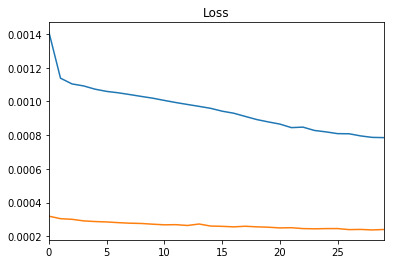

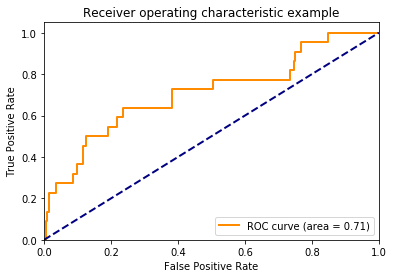

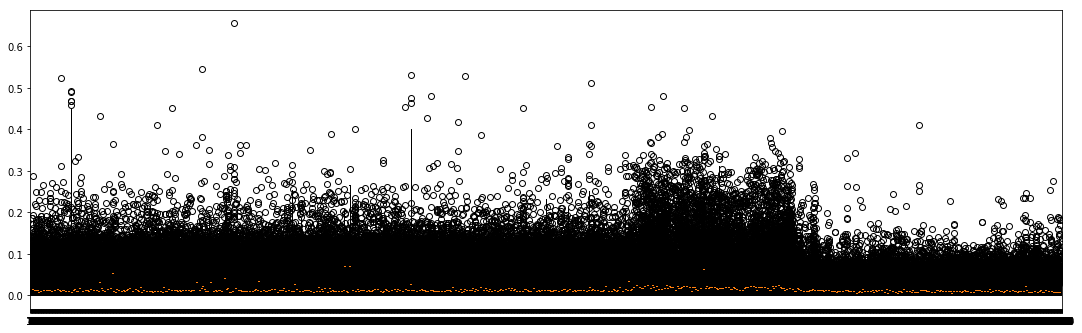

--- Online time: 4200.886282205582 seconds ---


In [14]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []
ein0 = []
aus0=[]
para_recorder = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
        
start_time = time.time()
for data in test_set_list:
        
        para_recorder.append([mu,sigma, threshold])
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})
        ein0.append(input_n.reshape(-1,))
        aus0.append(output_n.reshape(-1,))
        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
        output +=  [np.array(heapq.nlargest(10,scores)).mean()]
        #output += [scores.max()]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        e = [err.ravel()[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        for index,value in enumerate(pred):
            if value[value>threshold].size>=20: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                else:
                    #print("FP")
                    err_nbuf.append(e[index])
                    n_buf.append(df[index])
                    mu,sigma = update(err_nbuf,acc_size,mu,sigma)
                    mus.append(mu)
                    sigmas.append(sigma)
                    acc_size += step_num
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                else:
                    err_nbuf.append(e[index])
                    mu,sigma = update(err_nbuf,acc_size,mu,sigma)
                    mus.append(mu)
                    sigmas.append(sigma)
                    acc_size += step_num
                    #print("TN")
        count +=1
        

        
        if len(n_buf)>=100 and len(a_buf)>=10:
            print("retrain before %d batch"%count)
            loss_list_all=[]

            datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            

            
            #mu,sigma,threshold = update_parameter(err_nbuf,err_abuf,acc_size,mu,sigma,threshold)
            mu,sigma = update(err_nbuf,acc_size,mu,sigma,retraining=True)
            normal_score = []
            abnormal_score = []
            
            for val in validation_list_n:
                (ein,aus) = sess.run([input_,output_], {p_input: val,p_is_training :False})
                
                err = abs(ein-aus).reshape(-1,elem_num)
        
                normal_score +=scoring(err,mu,sigma)
            
            for val_a in validation_list_a:
                (ein,aus) = sess.run([input_,output_], {p_input: val_a,p_is_training :False})
                
                err = abs(ein-aus).reshape(-1,elem_num)
        
                abnormal_score +=scoring(err,mu,sigma)
            threshold = get_threshold(normal_score, abnormal_score)
        
            #print("New parameters: ",mu,sigma,threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)


plt.show()
print("--- Online time: %s seconds ---" % (time.time() - start_time))
            

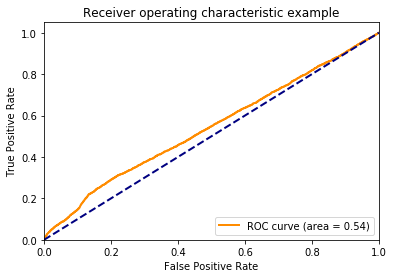

In [15]:
foo = pd.Series(np.array(all_scores).ravel())
fpr, tpr, thresholds = metrics.roc_curve(labels[1:], foo[1:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

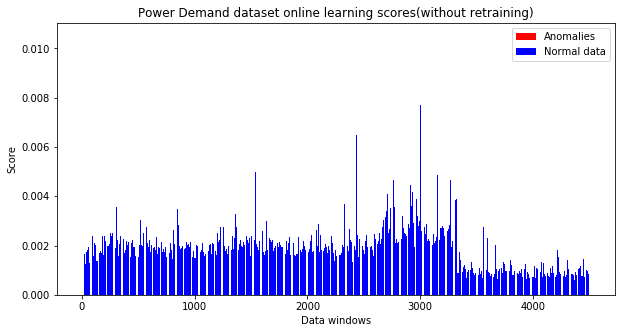

In [16]:
plt.figure(figsize=(10,5))
#barlist = plt.bar(range(len(output)),output)
#for x in anomaly_index:
#    barlist[x].set_color('r')
bar1 = plt.bar(anomaly_index,pd.Series(output)[anomaly_index],color='r')
bar2 = plt.bar(normal_index,pd.Series(output)[normal_index],color='b')
plt.legend([bar1,bar2], ["Anomalies","Normal data"])

plt.xlabel("Data windows")
plt.ylabel("Score")
plt.title("Power Demand dataset online learning scores(without retraining)")
plt.show()

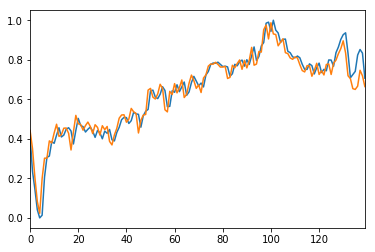

In [17]:
pd.Series(ein0[9]).plot()
pd.Series(aus0[9]).plot()


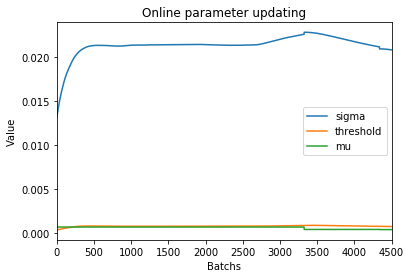

In [18]:
pd.DataFrame(para_recorder,columns={"mu","sigma","threshold"}).plot()
plt.title("Online parameter updating")
plt.xlabel("Batchs")
plt.ylabel("Value")
plt.show()

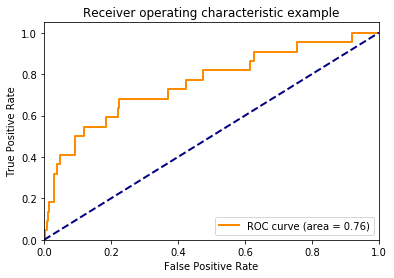

In [14]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []

ein = []
aus = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})
        ein.append(input_n.reshape(-1,))
        aus.append(output_n.reshape(-1,))
        
        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
        output += [scores.mean()]


fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
plot_roc(fpr,tpr,auc)


plt.show()

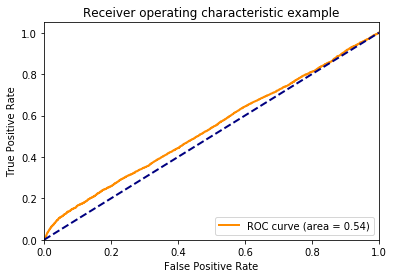

In [15]:
foo = pd.Series(np.array(all_scores).ravel())
fpr, tpr, thresholds = metrics.roc_curve(labels[1:], foo[1:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

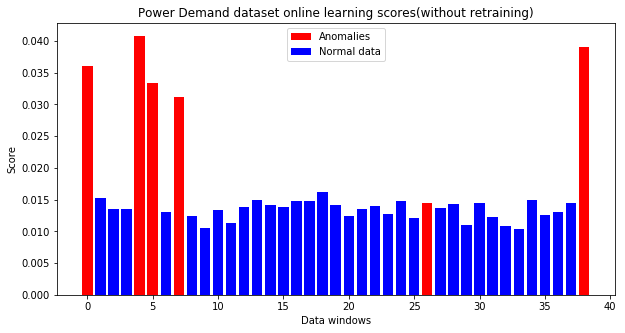

In [99]:
plt.figure(figsize=(10,5))
#barlist = plt.bar(range(len(output)),output)
#for x in anomaly_index:
#    barlist[x].set_color('r')
bar1 = plt.bar(anomaly_index,pd.Series(output)[anomaly_index],color='r')
bar2 = plt.bar(normal_index,pd.Series(output)[normal_index],color='b')
plt.legend([bar1,bar2], ["Anomalies","Normal data"])

plt.xlabel("Data windows")
plt.ylabel("Score")
plt.title("Power Demand dataset online learning scores(without retraining)")
plt.show()

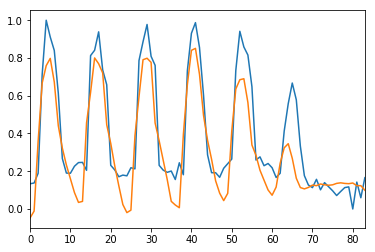

In [55]:
pd.Series(ein[26]).plot()
pd.Series(aus[26]).plot()


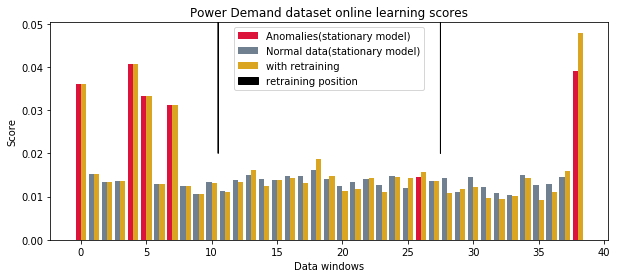

In [130]:
plt.figure(figsize=(10,4))
#barlist = plt.bar(range(len(output)),output)
#for x in anomaly_index:
#    barlist[x].set_color('r')
bar1 = plt.bar(np.array(anomaly_index)-0.2,pd.Series(output)[anomaly_index],color='crimson',width=0.4)
bar2 = plt.bar(np.array(normal_index)-0.2,pd.Series(output)[normal_index],color='slategray',width=0.4)

bar3 = plt.bar(np.arange(len(my_tmp))+0.2,pd.Series(my_tmp),color='goldenrod',width=0.4)
#bar4 = plt.bar(normal_index,pd.Series(my_tmp)[normal_index],color='y')
arrow = plt.arrow(10.5,0.02,0,0.03,color="black")
plt.arrow(27.5,0.02,0,0.03)
plt.legend([bar1,bar2,bar3,arrow], ["Anomalies(stationary model)","Normal data(stationary model)","with retraining","retraining position"])

plt.xlabel("Data windows")
plt.ylabel("Score")
plt.title("Power Demand dataset online learning scores")
plt.show()